In [ ]:
import keras
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from numpy import argmax
import numpy as np
import itertools
%matplotlib inline

MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 250

TEST_SPLIT = 0.2
n_classes = ["Oph","Uro","D","Ortho","GYN","P","S","G&H"]

In [2]:
def plot_confusion_matrix(cm, n_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams['font.size'] = 15
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(n_classes))
    plt.xticks(tick_marks, n_classes, rotation=45)
    plt.yticks(tick_marks, n_classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def one_hot2indices(one_hots):
    indices = []
    for one_hot in one_hots:
        indices.append(argmax(one_hot))
    return indices

In [4]:
train_texts = open('data/train_contents.txt').read().split('\n')
train_labels = open('data/train_labels.txt').read().split('\n')
test_texts = open('data/test_contents.txt').read().split('\n')
test_labels = open('data/test_labels.txt').read().split('\n')
all_texts = train_texts + test_texts
all_labels = train_labels + test_labels

In [5]:
print ('(2) doc to var...')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(all_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

(2) doc to var...
Found 51199 unique tokens.
Shape of data tensor: (24000, 50)
Shape of label tensor: (24000, 9)


In [6]:
print ('(3) split data set...')
# split the data into training set, validation set, and test set
p1 = 11000
p2 = -800
x_train = data[:p1]
y_train = labels[:p1]
x_val = data[p1:p2]
y_val = labels[p1:p2]
x_test = data[p2:]
y_test = labels[p2:]
print ('train docs: '+str(len(x_train)))
print ('val docs: '+str(len(x_val)))
print ('test docs: '+str(len(x_test)))

(3) split data set...
train docs: 11000
val docs: 12200
test docs: 800


CNN model

In [7]:
print ('CNN training model...')
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D
from keras.models import Sequential

CNN training model...


In [8]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))
model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(EMBEDDING_DIM, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))
model.summary()
#plot_model(model, to_file='model.png',show_shapes=True)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print (model.metrics_names)
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=200)
model.save('models/8_class_cnn.h5')


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 250)           12800000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 250)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 250)           187750    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 250)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1000250   
________________________________________________

In [7]:
from keras.models import load_model
model = load_model('models/8_class_cnn.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
print ('CNN testing model...')
#print (model.evaluate(x_test, y_test))

preds = model.predict(x_test)
y_test = one_hot2indices(y_test)
preds = one_hot2indices(preds)

from sklearn.metrics import accuracy_score
print("accuracy:"+ str(accuracy_score(y_test, preds)))

cm = metrics.confusion_matrix(y_test,preds)
print(cm)




CNN testing model...
accuracy:0.9375
[[100   0   0   0   0   0   0   0]
 [  0  99   0   0   0   0   1   0]
 [  0   0 101   0   0   0   0   0]
 [  0   0   0  99   1   0   0   0]
 [  0   0   0   0  99   0   0   0]
 [  0   0   0   0   0  99   0   0]
 [  0   3   0   1   0   0  96   0]
 [  3  16   0   4  10   5   6  57]]


In [12]:
print(classification_report(y_pred=preds, y_true=y_test))


              precision    recall  f1-score   support

           1       0.97      1.00      0.99       100
           2       0.84      0.99      0.91       100
           3       1.00      1.00      1.00       101
           4       0.95      0.99      0.97       100
           5       0.90      1.00      0.95        99
           6       0.95      1.00      0.98        99
           7       0.93      0.96      0.95       100
           8       1.00      0.56      0.72       101

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.93       800
weighted avg       0.94      0.94      0.93       800



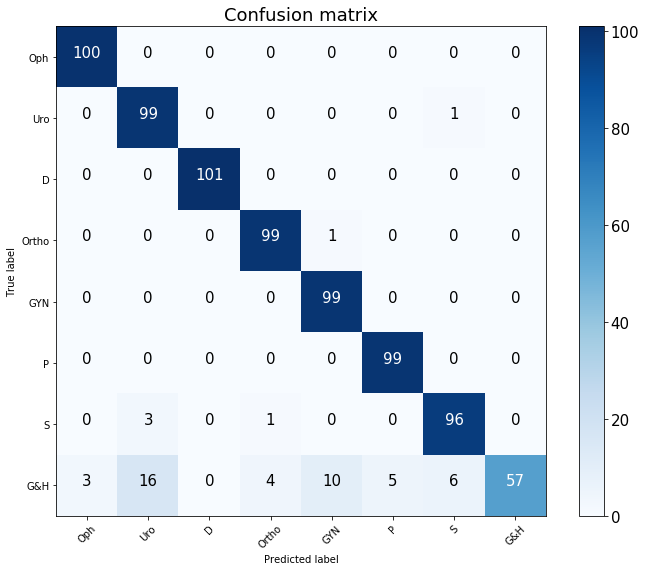

In [15]:
plot_confusion_matrix(cm, n_classes,
                      title='Confusion matrix')